In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import splitfolders
import nest_asyncio
nest_asyncio.apply()

import asyncio
from multiprocessing.dummy import Pool as ThreadPool
from pathlib import Path

import aiofiles
import aiohttp
import cv2
from aiofiles.os import remove as async_remove
from aiohttp import ClientConnectorError
from aiohttp.client_exceptions import ClientPayloadError, ServerDisconnectedError, ClientOSError
from tqdm import tqdm as tqdm_asyncio
import alembic

In [2]:
transform = transforms.ToTensor()

In [3]:
root = '../Desktop/WF'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes
labels = train_data.targets

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Aidan_Turner', 'Ashley_Rickards', 'Christina_Hendricks', 'Christine_Lahti', 'Cillian_Murphy', 'Dawn_French', 'Jacqueline_MacInnes_Wood', 'Kari_Matchett', 'Martha_Plimpton', 'Rowan_Atkinson', 'cash ', 'cats', 'fact', 'foot', 'heat', 'holt', 'lots', 'safe', 'soft', 'tell']
Training images available: 9002
Testing images available:  1680


In [4]:
train_data.classes

['Aidan_Turner',
 'Ashley_Rickards',
 'Christina_Hendricks',
 'Christine_Lahti',
 'Cillian_Murphy',
 'Dawn_French',
 'Jacqueline_MacInnes_Wood',
 'Kari_Matchett',
 'Martha_Plimpton',
 'Rowan_Atkinson',
 'cash ',
 'cats',
 'fact',
 'foot',
 'heat',
 'holt',
 'lots',
 'safe',
 'soft',
 'tell']

In [5]:
torch.manual_seed(101)  

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

Label: [    8    10     6    19    12    12     0     5    14     5]
Class:  Martha_Plimpton cash  Jacqueline_MacInnes_Wood tell fact fact Aidan_Turner Dawn_French heat Dawn_French


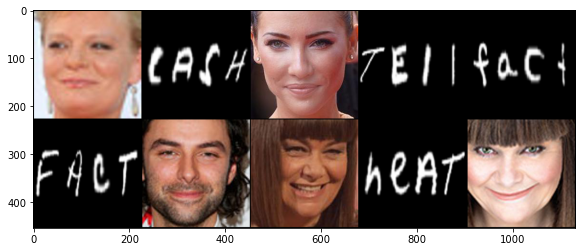

In [6]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))

for images,labels in train_loader: 
    break

print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))


im = make_grid(images, nrow=5) 
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [13]:
out1 = 32

In [18]:
class ConvolutionalNetwork(nn.Sequential):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 24, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(24, 12, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(12, 24, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(24, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, out1, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
         
        self.fc_m = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5*5*out1, 240),
            nn.ReLU(),
            nn.Linear(240,10))

        self.fc_c = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5*5*out1, 240),
            nn.ReLU(),
            nn.Linear(240,20))
        

def forward(self, X):
        X1 = self.layer1(X)
        
        Xm = X.view(-1, 5*5*out1)
        Xc = X.view(-1, 5*5*out1)
        
        Xm = self.fc_m(Xm)
        Xc = self.fc_c(Xc)
        
        return F.log_softmax(Xm, dim=1)
        return F.log_softmax(Xc, dim=1)

In [19]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_m): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=800, out_features=240, bias=True)
    (2): ReLU()
    (3): 

In [20]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [21]:
count_parameters(model)

   648
    24
  2592
    12
  2592
    24
  6912
    32
  9216
    32
192000
   240
  2400
    10
192000
   240
  4800
    20
______
413794


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # results
        if b%100 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/9002]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%  Duration: {time.time() - start_time:.0f} seconds')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            
            y_val = model(X_test)

            # Tally number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x10 and 800x240)